In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf #needed for models in this script
import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
pd.set_option('html', True) #see the dataframe in a more user friendly manner
%matplotlib inline

## Decision Trees Overview

Consider a pool of college applicants. The average SAT score for admission has historically been 2,200, and the average GPA 4.9. We are given the application info on 1,000 applicants and asked to create a model that will allow us to predict students most likely to be admitted. How do we go about doing this?

One approach would be to first divide the applicants into those that have SAT score over 2,200 and then call this the "more likely" group. Then we could split this group further by GPA based on whether their GPA is less than or equal to 4.9 or over 4.9. We call the latter subgroup "most likely" and the former a "high maybe". Then we do the same thing to the group with SAT scores below 2,200 calling the high GPA subgroup a "maybe", and the low GPA subgroup a "probably not".

The following is an example of how the decision tree looks for this problem.

![](files/dtree1.jpg)

1. What do you think would happen if we split on GPA first and then SAT scores---would we get the same groupings? (i.e. what is the best way to split?)
2. What if we used more criteria such as essay evaluation scores, extra curriculars, awards and distinctions in sports etc? (i.e. how many attributes should we use to create splits, and what are the most significant attributes?)
3. We were given averages, but what about the spread, what about outliers? (i.e. how does the distribution of attributes affect misclassification?)

A <u>decision tree</u> uses the intrinsic structure of the data to make these splits. Decision trees are commonly used in operations research, specifically in decision analysis, to help identify a strategy most likely to reach a goal. In machine learning, decision trees are commonly used to help identify features, and specific values of those features, that are most likely to result in a target value. If the target value is categorical, the model is a classification tree; if the target value is continuous, the model is a regression tree.

In this lesson, we're going to focus on classification trees.

## Data Cleaning and Exploration

Download and unzip UCI HAR Dataset.zip from: https://github.com/shubhabrataroy/Thinkful/tree/master/Data/Unit4.2.2

 * Read through features_info.txt (https://www.dropbox.com/s/mnj4x46z7jb3xw7/features_info.txt?dl=0). This file describes each feature, its physical significance, and also describes features that are derived from raw data by doing some averaging, or sampling, or some operation that gives a numerical result. What do you notice about the dataset? What kind of guidelines for approaching the dataset do you find?
 
 * In static activities (sit, stand, lie down) motion information will not be very useful.
 
 * In the dynamic activities (3 types of walking) motion will be significant.
 
 * Angle variables will be useful both in differentiating “lie vs stand” and “walk up vs walk down”.
 
 * Acceleration and Jerk variables are important in distinguishing various kinds of motion while filtering out random tremors while static.  
 
 * Mag and Angle variables contain the same info as (e.g., are strongly correlated with) XYZ variables. We choose to focus on the latter as they are simpler to reason about. This is a very important point to understand as it results in elimination of a few hundred variables.
 
 * We ignore the band variables as we have no simple way to interpret the meaning and relate them to physical activities.
 
 * mean and std are important, skewness and kurtosis may also so we include all of these.

<b>Clean-Up:</b> for each of the tasks below, think about how you will fix the data and what the implications/ramifications of your fixes will be. Also, can you think of a way to accomplish several of the cleaning tasks at once?

* Identify and fix the inclusion of ( ) in column names. <b>Think I have this one</b>
* Identify and remove duplicate column names. <b>Do I need a function that loops over the column names and appends duplicates to a list? Then I use drop function to drop that list of duplicates?</b>
* Identify and fix the inclusion of ‘-’ in column names. <b>Think I have this one</b>
* Identify and fix extra ) in some column names. <b>Think I have this one</b>
* Identify and fix inclusion of multiple ‘,’ in column names. <b>Not Sure</b>
* Identify and fix column names containing “BodyBody” <b>Think I have this one</b>
* Drop 'Body' and 'Mag' from column names. <b>Think I have this one</b>
* Map 'mean' and 'std' to 'Mean' and 'STD' <b>Think I have this one</b>
* Make 'activity' a categorical variable.
* Plot a histogram of Body Acceleration Magnitude (i.e. histogram of all 6 activities) to see how each variable does as a predictor of static versus dynamic activities.

<b>Open Data:</b>

In [3]:
frame = pd.read_csv('samsungdata.csv')
frame.head(1)

,Unnamed: 0,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,activity
0,1,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,...,-0.710304,-0.112754,0.0304,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,standing


<b>Clean Data Column Headers:</b>

In [4]:
def fix_column_headers(dataframe):
    
    dataframe.rename(columns=lambda x: x.replace('()', ''), inplace=True) #Identify and fix the inclusion of ( ) in column names.
    dataframe.rename(columns=lambda x: x.replace('-', ''), inplace=True) #Identify and fix the inclusion of ‘-’ in column names.
    dataframe.rename(columns=lambda x: x.replace('))', ')'), inplace=True) #Identify and fix extra ) in some column names.
    dataframe.rename(columns=lambda x: x.replace('BodyBody', ''), inplace=True) #Identify and fix column names containing “BodyBody” names.
    dataframe.rename(columns=lambda x: x.replace('Body', ''), inplace=True) #Drop 'Body' and 'Mag' from column names.
    dataframe.rename(columns=lambda x: x.replace('Mag', ''), inplace=True) #Drop 'Body' and 'Mag' from column names.
    dataframe.rename(columns=lambda x: x.replace('mean', 'Mean'), inplace=True) #Map 'mean' and 'std' to 'Mean' and 'STD'
    dataframe.rename(columns=lambda x: x.replace('std', 'STD'), inplace=True) #Map 'mean' and 'std' to 'Mean' and 'STD'
    
    return dataframe
    

<b>Note:</b> Not necessary to clean column headers to perform a random forest classifier. 

## Random Forest Analysis

Decision Trees present a simple and clean conceptual model to understand classification via an iterative procedure. However, in practice, a single decision tree is not very useful for real world problems involving a large number of variables and larger datasets. In the same way that large problems are rarely solved by just one expert, a lot of data with a lot of variables probably can't be either. We need several experts. So what do we mean by "expert" in the context of decision trees?

Imagine that an expert has a decision tree model in their head. We assemble, say, 100 experts and find that each expert's model differs slightly. We can call this a decision forest. The idea behind the random forest method is to produce a model that is, in the aggregate, more accurate than the prediction of any individual decision tree. Essentially, a random forest works as follows:

1. Grow a large number of decision trees on your training data.
2. For each tree, use only a random subset of features and random subset of datapoints. This prevents overfitting by not letting all of the trees use the same features.
3. Make predictions by aggregating over each decision trees' individual predctions.

<b>Random forests provide an extremely useful measure known as feature importances.</b> This is basically calculated by measuring which features are the best at predicting what we want, across all of the trees in the random forest. Before completing the follow excercise, read the supplmental introduction to random forests here: http://blog.yhathq.com/posts/random-forests-in-python.html

## Blog Example

Random forest is a highly versatile machine learning method with numerous applications ranging from marketing to healthcare and insurance. It can be used to model the impact of marketing on customer acquisition, retention, and churn or to predict disease risk and susceptibility in patients.

Random forest is a capable of regression and classification. It can handle a large number of features, and it's helpful for estimating which or your variables are important in the underlying data being modeled.

<b>What is a Random Forest?</b>

Random forest is solid choice for nearly any prediction problem (even non-linear ones). It's a relatively new machine learning strategy (it came out of Bell Labs in the 90s) and it can be used for just about anything. It belongs to a larger class of machine learning algorithms called ensemble methods.

<u>Ensemble Learning</u>

Ensemble learning involves the combination of several models to solve a single prediction problem. It works by generating multiple classifiers/models which learn and make predictions independently. Those predictions are then combined into a single (mega) prediction that should be as good or better than the prediction made by any one classifer.

Random forest is a brand of ensemble learning, as it relies on an ensemble of decision trees. More on ensemble learning in Python here: (http://scikit-learn.org/dev/modules/ensemble.html)

<u>Randomized Decision Trees</u>

So we know that random forest is an aggregation of other models, but what types of models is it aggregating? As you might have guessed from its name, random forest aggregates Classification (or Regression) Trees. A decision tree is composed of a series of decisions that can be used to classify an observation in a dataset.

<u>Random Forest</u>

The algorithm to induce a random forest will create a bunch of random decision trees automatically. Since the trees are generated at random, most won't be all that meaningful to learning your classification/regression problem (maybe 99.9% of trees).

![](files/dtree2.jpg)

*If an observation has a length of 45, blue eyes, and 2 legs, it's going to be classified as red.

<u>Arboreal Voting</u>

So what good are 10000 (probably) bad models? Well it turns out that they really aren't that helpful. But what is helpful are the few really good decision trees that you also generated along with the bad ones.

When you make a prediction, the new observation gets pushed down each decision tree and assigned a predicted value/label. Once each of the trees in the forest have reported its predicted value/label, the predictions are tallied up and the mode vote of all trees is returned as the final prediction.

Simply, the 99.9% of trees that are irrelevant make predictions that are all over the map and cancel each another out. The predictions of the minority of trees that are good top that noise and yield a good prediction.

<u>Why you should I use it?</u>

It's Easy. Random forest is the Leatherman of learning methods. You can throw pretty much anything at it and it'll do a serviceable job. It does a particularly good job of estimating inferred transformations, and, as a result, doesn't require much tuning like SVM (i.e. it's good for folks with tight deadlines).

<u>An Example Transformation</u>

Random forest is capable of learning without carefully crafted data transformations. Take the the f(x) = log(x) function for example. Create some fake data and add a little noise:

In [4]:
blog_x = np.random.uniform(1, 100, 1000)
blog_y = np.log(blog_x) + np.random.normal(0, .3, 1000)

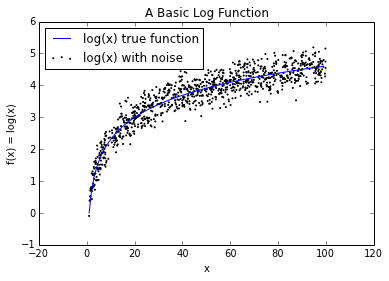

In [5]:
pl.scatter(blog_x, blog_y, s=1, label="log(x) with noise")
pl.plot(np.arange(1, 100), np.log(np.arange(1, 100)), c="b", label="log(x) true function")
pl.xlabel("x")
pl.ylabel("f(x) = log(x)")
pl.legend(loc="best")
pl.title("A Basic Log Function")

If we try and build a basic linear model to predict y using x we wind up with a straight line that sort of bisects the log(x) function. Whereas if we use a random forest, it does a much better job of approximating the log(x) curve and we get something that looks much more like the true function:

![](files/dtree3.jpg)

You could argue that the random forest overfits the log(x) function a little bit. Either way, I think this does a nice job of illustrating how the random forest isn't bound by linear constraints.

<u>Variable Selection</u>

One of the best use cases for random forest is feature selection. One of the byproducts of trying lots of decision tree variations is that you can examine which variables are working best/worst in each tree.

When a certain tree uses a one variable and another doesn't, you can compare the value lost or gained from the inclusion/exclusion of that variable. The good random forest implementations are going to do that for you, so all you need to do is know which method or variable to look at.

In the following examples, we're trying to figure out which variables are most important for classifying a wine as being red or white.

![](files/dtree4.jpg)

<u>Classification</u>

Random forest is also great for classification. It can be used to make predictions for categories with multiple possible values and it can be calibrated to output probabilities as well. One thing you do need to watch out for is overfitting. Random forest can be prone to overfitting, especially when working with relatively small datasets. You should be suspicious if your model is making "too good" of predictions on our test set.

One way to overfitting is to only use really relevant features in your model. While this isn't always cut and dry, using a feature selection technique (like the one mentioned previously) can make it a lot easier.

![](files/dtree5.jpg)

<u>Regression</u>

Yep. It does regression too. I've found that random forest--unlike other algorithms--does really well learning on categorical variables or a mixture of categorical and real variables. Categorical variables with high cardinality (# of possible values) can be tricky, so having something like this in your back pocket can come in quite useful.

## Python Example from Blog

Scikit-Learn is a great way to get started with random forest. The scikit-learn API is extremely consistent across algorithms, so you horse race and switch between models very easily. A lot of times I start with something simple and then move to random forest.

One of the best features of the random forest implementation in scikit-learn is the n_jobs parameter. This will automatically parallelize fitting your random forest based on the number of cores you want to use. Here's a great presentation by scikit-learn contributor Olivier Grisel where he talks about training a random forest on a 20 node EC2 cluster: https://vimeo.com/63269736

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
iris = pd.read_csv('iris.data.txt', header=None, sep = ',')
iris.columns = ['sepal_len', 'sepal_width', 'petal_len', 'petal_width', 'class']
iris.head()

,sepal_len,sepal_width,petal_len,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [88]:
iris['is_train'] = np.random.uniform(0,1, len(iris)) <= 0.8
iris['class'] = iris['class'].astype('category')
iris.head()

,sepal_len,sepal_width,petal_len,petal_width,class,is_train
0,5.1,3.5,1.4,0.2,Iris-setosa,True
1,4.9,3.0,1.4,0.2,Iris-setosa,True
2,4.7,3.2,1.3,0.2,Iris-setosa,True
3,4.6,3.1,1.5,0.2,Iris-setosa,True
4,5.0,3.6,1.4,0.2,Iris-setosa,True


In [89]:
iris.dtypes

sepal_len       float64
sepal_width     float64
petal_len       float64
petal_width     float64
class          category
is_train           bool
dtype: object

In [90]:
train, test = iris[iris['is_train']==True], iris[iris['is_train']==False]
print train[:2]
print test[:2]

   sepal_len  sepal_width  petal_len  petal_width        class is_train
0        5.1          3.5        1.4          0.2  Iris-setosa     True
1        4.9          3.0        1.4          0.2  Iris-setosa     True
   sepal_len  sepal_width  petal_len  petal_width        class is_train
5        5.4          3.9        1.7          0.4  Iris-setosa    False
7        5.0          3.4        1.5          0.2  Iris-setosa    False


In [91]:
features = iris.columns[:4]
iris_rf_model = RandomForestClassifier(n_jobs=2)
y, _ = pd.factorize(train['class'])
iris_rf_model.fit(train[features], y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [92]:
target_names = pd.Series.unique(iris['class'])
target_names

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [93]:
preds = target_names[iris_rf_model.predict(test[features])]
preds

array(['Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-setosa', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-virginica',
       'Iris-virginica', 'Iris-virginica', 'Iris-virginica',
       'Iris-virginica', 'Iris-versicolor', 'Iris-virginica',
       'Iris-virginica', 'Iris-virginica'], dtype=object)

In [94]:
pd.crosstab(test['class'], preds, rownames=['actual'], colnames=['preds'])

preds,Iris-setosa,Iris-versicolor,Iris-virginica
actual,,,
Iris-setosa,10,0,0
Iris-versicolor,0,7,0
Iris-virginica,0,1,8


In [128]:
#Score training data:
score_train = iris_rf_model.score(train.ix[:, :4], train.ix[:, 4])

In [129]:
score_train

0.0

In [130]:
#Score testing data:
score_testing = iris_rf_model.score(test.ix[:, :4], test.ix[:, 4])

In [131]:
score_testing

0.0

<b>Comment:</b> I'm not sure why my score functions aren't working? 

## Thinkful Random Forest Problem

In Olympic gymnastic and diving competitions, a panel of judges scores a participant. The top and bottom scores are dropped and the rest are averaged. A random forest algorithm uses similar techniques to eliminate some of the trees' predictions. Each round, the algorithm will randomly drop some number of trees. It then averages the result after some number of iterations.

We're going to train a random forest classifier on the subset of features we pulled out based on what we learned during data cleaning and exploration. Please use scikit-learn's implenetation, as it provides easy access to feature importances after fitting your model.

* Split the data into training, test, and validation sets.
* Fit a random forest classifier with 500 estimators to your training set.
* Rank the features by their importance scores. What are the top 10 important features? What is the 10th feature's importance score?
* What is your model's mean accuracy score on the validation and test sets?
* What is your model's precision and recall score on the test set?

In [132]:
#recall data:
frame.head(1)

,Unnamed: 0,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,activity
0,1,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,...,-0.710304,-0.112754,0.0304,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,standing


In [135]:
#split into training and testing and sets:
frame['is_train'] = np.random.uniform(0,1, len(frame)) <= 0.7

In [136]:
train_samsung, test_samsung = frame[frame['is_train']==True], frame[frame['is_train']==False]

In [148]:
samsung_rf = RandomForestClassifier() #name the model
sam_X_train = train_samsung[train_samsung.columns[1:-2]] #take all columns except the 'unnamed column' and activity
sam_Y_train = train_samsung.activity #take just the activity column

sam_X_test = test_samsung[test_samsung.columns[1:-2]] #take all columns except the 'unnamed column' and activity
sam_Y_test = test_samsung.activity #take just the activity column

In [149]:
#train the model on the training data:
samsung_rf.fit(sam_X_train, sam_Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [150]:
#test the score on training data: (Should be very high)
samsung_rf.score(sam_X_train, sam_Y_train)

0.99922435524529762

In [166]:
#Which attributes are most important; Note: returns the index position of the attribute
att_importance = np.argsort(samsung_rf.feature_importances_)[::-1] #Note: [::-1] reverses the order so the most important 
#feature index positions are at the top of the array instead of the bottom. 
att_importance[:50]

array([ 56, 348,  52,  49,  50, 350,  74, 559,  51, 234, 102, 344,  83,
        99, 366, 257,  53,  57, 209,  58, 508, 503,  40, 201, 560,  71,
       265, 215,  70,  42,  41, 302,  75, 203, 219, 214, 426, 512, 296,
       281,  54, 210, 558, 460,  86, 163,  68,  76,  37, 445], dtype=int64)

In [183]:
#Get names of the 20 most important features:
cols = frame.columns[1:-2]
for i in range(20):
    feature = cols[att_importance][i]
    print 'Feature',(i + 1),' ', feature

Feature 1   tGravityAcc-energy()-X
Feature 2   fBodyAccJerk-std()-Y
Feature 3   tGravityAcc-min()-X
Feature 4   tGravityAcc-max()-X
Feature 5   tGravityAcc-max()-Y
Feature 6   fBodyAccJerk-mad()-X
Feature 7   tGravityAcc-arCoeff()-Z,2
Feature 8   angle(Y,gravityMean)
Feature 9   tGravityAcc-max()-Z
Feature 10   tBodyAccJerkMag-entropy()
Feature 11   tBodyAccJerk-entropy()-X
Feature 12   fBodyAccJerk-mean()-X
Feature 13   tBodyAccJerk-std()-X
Feature 14   tBodyAccJerk-iqr()-X
Feature 15   fBodyAccJerk-entropy()-X
Feature 16   tBodyGyroJerkMag-sma()
Feature 17   tGravityAcc-min()-Y
Feature 18   tGravityAcc-energy()-Y
Feature 19   tBodyAccMag-arCoeff()1
Feature 20   tGravityAcc-energy()-Z


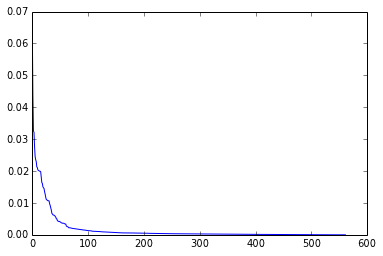

In [184]:
#plot the importance of features:
plt.plot(samsung_rf.feature_importances_[att_importance])

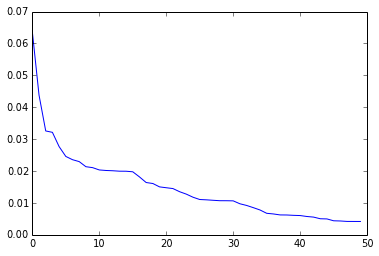

In [187]:
#plot top 50 features:
plt.plot(samsung_rf.feature_importances_[att_importance][:50])

In [188]:
#Evaluate Model on Test Data:
samsung_rf.score(sam_X_test, sam_Y_test)

0.96947608200455582

<b>Comment:</b> The score for the test data seems to high, I have a feeling I've made a mistake somewhere. 

<b>Further Comment:</b> I did not complete the 'black box' example. I will complete several more examples of this algorithm from examples with full instructions online until I feel comfortable implementing in real life. This lesson has given me a feel for it; something I didn't have before!